# Temporal Difference Methods

In [ ]:
from IPython.lib.display import YouTubeVideo

In [ ]:
YouTubeVideo('yXErXQulI_o')

In [ ]:
YouTubeVideo('ZwIg6LDMyuo')

## SARSA

In [ ]:
YouTubeVideo('HYV0SP9wm7g')

In [ ]:
YouTubeVideo('U_CV-UC9G2c')

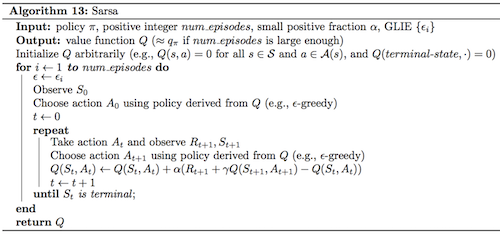

## Q-Learning 

In [ ]:
YouTubeVideo('4DxoYuR7aZ4')

Check out this [research paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.80.7501&rep=rep1&type=pdf) to read the proof that Q-Learning (or Sarsamax) converges.

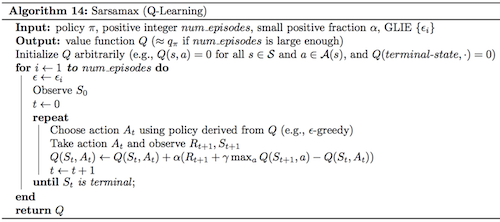

## Expected SARSA

In [ ]:
YouTubeVideo('kEKupCyU0P0')

Check out this [research paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.216.4144&rep=rep1&type=pdf) to learn more about Expected Sarsa.

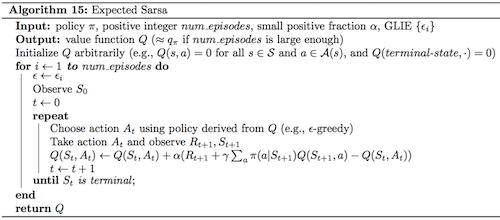

#### In Theory
All of the TD control algorithms (Sarsa, Sarsamax, Expected Sarsa) are **guaranteed to converge** to the optimal action-value function $q^*$ (and so yield the optimal policy $\pi^*$) as long as the step-size parameter $\alpha$ is sufficiently small, and the **GLIE** conditions are met. Once we have a good estimate for $q^*$, a corresponding optimal policy $\pi^*$ can then be quickly obtained by setting $\pi^*(s)=\displaystyle\arg\max_{a\in\mathcal{A}(s)}q^*(s,a)\quad\forall s\in\mathcal{S}$

#### In practice
In practice, it is common to completely ignore the GLIE conditions (by setting a constant $\epsilon$) and still recover an optimal policy.

#### Optimism
For any TD control method, we must begin by initializing the values in the Q-table. It has been shown that [initializing the estimates to large values](http://papers.nips.cc/paper/1944-convergence-of-optimistic-and-incremental-q-learning.pdf) can improve performance. For instance, if all of the possible rewards that can be received by the agent are negative, then initializing every estimate in the Q-table to zeros is a good technique. In this case, we refer to the initialized Q-table as **optimistic**, since the action-value estimates are guaranteed to be larger than the true action values.

#### Similarities
All of the TD control methods we have examined (Sarsa, Sarsamax, Expected Sarsa) converge to the optimal action-value function $q^*$ (and so yield the optimal policy $\pi^*$) if:
 1. The value of $\epsilon$ decays in accordance with the **GLIE** conditions, and
 2. The step-size parameter $\alpha$ is sufficiently small.

#### Differences
The differences between these algorithms are summarized below:
  1. Sarsa and Expected Sarsa are both on-policy TD control algorithms. In this case, the same ($\epsilon$-greedy) policy that is evaluated and improved is also used to select actions.
  2. Sarsamax is an off-policy method, where the (greedy) policy that is evaluated and improved is different from the ($\epsilon$-greedy) policy that is used to select actions.
  3. On-policy TD control methods (like Expected Sarsa and Sarsa) have better online performance than off-policy TD control methods (like Sarsamax).
  4. Expected Sarsa generally achieves better performance than Sarsa.
  5. Q Learning learns **a deterministic optimal policy** even if its behaviour policy is totally random.
  6. Sarsa learns **the best exploratory policy** i.e. the best policy that still explores.

---

### Explore CliffWalking Environment

In [ ]:
import sys
import gym
import time
import numpy as np
from collections import defaultdict, deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from utils.plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [ ]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [ ]:
print(env.observation_space)
print(env.action_space)

In this notebook, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.

In [ ]:
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### TD Control: SARSA

In this section, we will write our own implementation of the SARSA control algorithm.

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [ ]:
def update_Q(Qsa, Qsa_next, reward, alpha, gamma):
    """ updates the action-value function estimate using the most recent time step """
    return Qsa + (alpha * (reward + (gamma * Qsa_next) - Qsa))

def epsilon_greedy_probs(env, Q_s, i_episode, eps=None):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    epsilon = 1.0 / i_episode
    if eps is not None:
        epsilon = eps
    policy_s = np.ones(env.nA) * epsilon / env.nA
    policy_s[np.argmax(Q_s)] = 1 - epsilon + (epsilon / env.nA)
    return policy_s

In [ ]:
def sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        # initialize score
        score = 0
        # begin an episode, observe S
        state = env.reset()   
        # get epsilon-greedy action probabilities
        policy_s = epsilon_greedy_probs(env, Q[state], i_episode)
        # pick action A
        action = np.random.choice(np.arange(env.nA), p=policy_s)
        # limit number of time steps per episode
        for t_step in np.arange(300):
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            # add reward to score
            score += reward
            if not done:
                # get epsilon-greedy action probabilities
                policy_s = epsilon_greedy_probs(env, Q[next_state], i_episode)
                # pick next action A'
                next_action = np.random.choice(np.arange(env.nA), p=policy_s)
                # update TD estimate of Q
                Q[state][action] = update_Q(Q[state][action], Q[next_state][next_action], 
                                            reward, alpha, gamma)
                # S <- S'
                state = next_state
                # A <- A'
                action = next_action
            if done:
                # update TD estimate of Q
                Q[state][action] = update_Q(Q[state][action], 0, reward, alpha, gamma)
                # append score
                tmp_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [ ]:
Q_sarsa = sarsa(env, 5000, 0.01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### TD Control: Q-learning

In this section, we will write our own implementation of the Q-learning control algorithm.

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [ ]:
def q_learning(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # initialize score
        score = 0
        # begin an episode, observe S
        state = env.reset()
        while True:
            # get epsilon-greedy action probabilities
            policy_s = epsilon_greedy_probs(env, Q[state], i_episode)
            # pick next action A
            action = np.random.choice(np.arange(env.nA), p=policy_s)
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            # add reward to score
            score += reward
            # update Q
            Q[state][action] = update_Q(Q[state][action], np.max(Q[next_state]), \
                                                  reward, alpha, gamma)        
            # S <- S'
            state = next_state
            # until S is terminal
            if done:
                # append score
                tmp_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [ ]:
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### TD Control: Expected SARSA

In this section, we will write our own implementation of the Expected Sarsa control algorithm.

The algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [ ]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor
    plot_every = 100
    tmp_scores = deque(maxlen=plot_every)
    scores = deque(maxlen=num_episodes)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # initialize score
        score = 0
        # begin an episode
        state = env.reset()
        # get epsilon-greedy action probabilities
        policy_s = epsilon_greedy_probs(env, Q[state], i_episode, 0.005)
        while True:
            # pick next action
            action = np.random.choice(np.arange(env.nA), p=policy_s)
            # take action A, observe R, S'
            next_state, reward, done, info = env.step(action)
            # add reward to score
            score += reward
            # get epsilon-greedy action probabilities (for S')
            policy_s = epsilon_greedy_probs(env, Q[next_state], i_episode, 0.005)
            # update Q
            Q[state][action] = update_Q(Q[state][action], np.dot(Q[next_state], policy_s), \
                                                  reward, alpha, gamma)        
            # S <- S'
            state = next_state
            # until S is terminal
            if done:
                # append score
                tmp_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

In [ ]:
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

### Watch a Trained Agent in Action

In [ ]:
policies = {'SARSA': policy_sarsa, 'Q-Learning': policy_sarsamax, 'Expected-SARSA': policy_expsarsa}
policy = policies['Expected-SARSA']

#### Simulate the Agent

In [ ]:
state = env.reset()
clear_output(wait=True)
print(env.render(mode='ansi'))
while True:
    action = policy[state // 12][state % 12]
    state, _, done, _ = env.step(action)
    time.sleep(1)
    clear_output(wait=True)
    print(env.render(mode='ansi'))
    if done:
        break

In [ ]:
env.close()

---

Next: [TD Learning OpenAI Gym Taxi](./TD%20Learning%20OpenAI%20Gym%20Taxi.ipynb)